<a href="https://colab.research.google.com/github/alecinvan/Colab_AI_tutorial/blob/main/database_query_by_gemini_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="darkred" size="6"> 通过自然语言和数据库进行交互以便为企业提供AI解决方案

*   Google Gemini Pro模型。
*   SQLite DB。

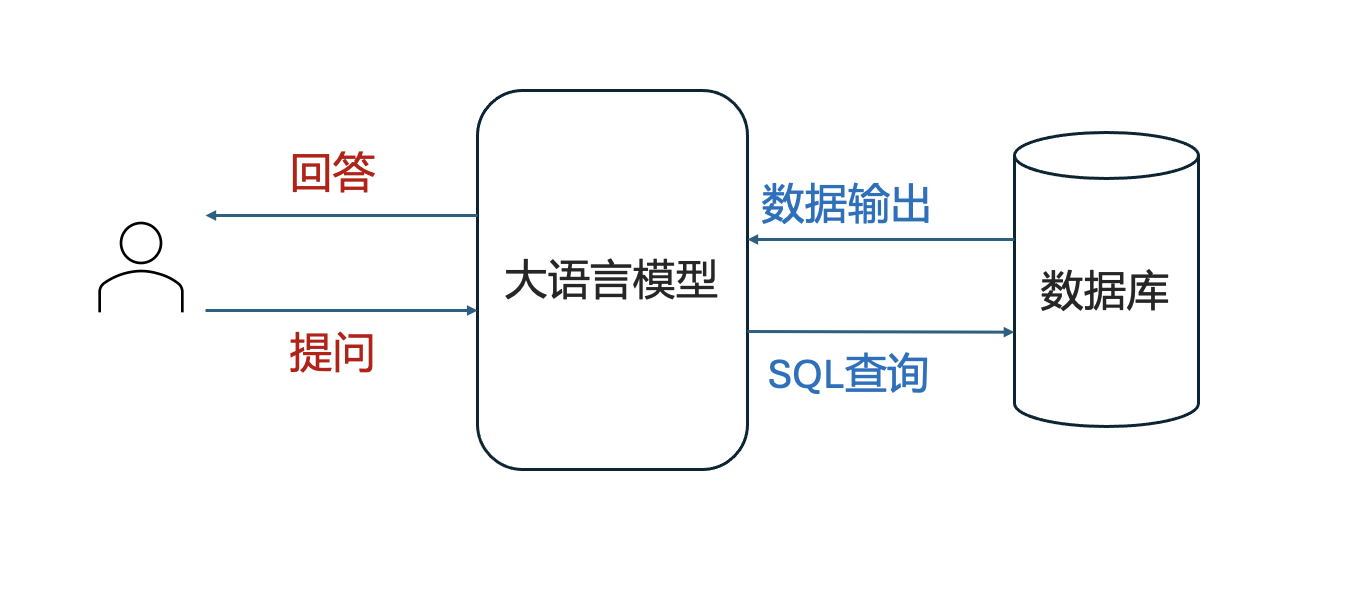

In [ ]:
from PIL import Image               # to load images
from IPython.display import display # to display images

pil_im = Image.open('/content/llm2db.png')
display(pil_im)

# <font color="blue" >安装依赖

In [ ]:
!pip install -q google-generativeai==0.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 1.7 MB/s eta 0:00:00


# <font color="blue" >导入依赖库

In [ ]:
import google.generativeai as genai
from pathlib import Path
import sqlite3

# <font color="blue" >版本

In [ ]:
genai.__version__

'0.3.2'

# <font color="blue">Gemini密钥

In [ ]:
from google.colab import userdata

genai.configure(api_key = userdata.get('GEMINI_KEY'))

# <font color="blue" > 安全配置

In [ ]:
# Set up the model
generation_config = {
  "temperature": 0.4,
  "top_p": 1,
  "top_k": 32,
  "max_output_tokens": 4096,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  }
]

# <font color="blue" >模型实例Gemini-Pro

In [ ]:
model = genai.GenerativeModel(model_name = "gemini-pro",
                              generation_config = generation_config,
                              safety_settings = safety_settings)

# <font color="blue" >SQL查询执行器

In [ ]:
def read_sql_query(sql, db):
    conn = sqlite3.connect(db)
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    for row in rows:
        print(row)
    conn.close()

In [ ]:
read_sql_query('SELECT * FROM fashion_products LIMIT 10;',
               "fashion_db.db")

(19, 1, 'Dress', 'Adidas', "Men's Fashion", 45, 1.084848, 'Black', 'XL')
(25, 2, 'Shoes', 'Nike', "Women's Fashion", 56, 2.084848, 'White', 'L')
(97, 3, 'Dress', 'Zara', "Women's Fashion", 89, 3.084848, 'Blue', 'XL')
(98, 4, 'T-shirt', 'Michael Kors', "Men's Fashion", 90, 5.084848, 'Yellow', 'XXL')
(99, 5, 'Dress', 'Canada Goose', "Women's Fashion", 230, 4.000013, 'Black', 'M')
(100, 6, 'Dress', 'Zara', "Women's Fashion", 120, 3.026416, 'White', 'L')
(101, 7, 'Sweater', 'BOSS', "Men's Fashion", 200, 9.026416, 'White', 'XL')
(102, 8, 'T-shirt', 'Gucci', "Women's Fashion", 340, 7.026416, 'Green', 'S')
(103, 9, 'Shoes', 'Blundstone', "Women's Fashion", 192, 6.026416, 'Brown', 'M')
(104, 10, 'Sweater', 'Deckers', "Kids' Fashion", 112, 8.026416, 'Black', 'S')


# <font color="blue">定义提示

In [ ]:
prompt_parts_1 = [
  "You are an expert in converting English questions to SQL code! The SQL database has the name fashion_products and has the following columns - user_id, product_id, product_name, brand, category, price, color, and size.\n\nFor example,\nExample 1 - How many entries of Adidas are present?, the SQL command will be something like this\n``` SELECT COUNT(*) FROM fashion_products WHERE brand = 'Adidas';\n```\n\nExample 2 - How many XL products of Nike are there that have a rating of more than 4?\n```\nSELECT COUNT(*) FROM fashion_products WHERE brand = 'Nike' AND size = 'XL' AND \"Rating\" > 4;\n```\n\nExample 3 - \n```\nSELECT product_name FROM fashion_products WHERE price = (SELECT MAX(price) FROM fashion_products);\n```\n\nDont include ``` and \\n in the output",
]

<font color="blue" >您是一位把问题转换为SQL语句的专家！SQL数据库的名称为 Fashion_products，并具有以下字段
*   user_id
*   product_id
*   product_name
*   brand
*   category
*   price
*   color
*   size

<font color="blue" >示例：
1.   有多少个 Adidas 条目？，SQL 命令将类似于此\n``` SELECT COUNT(*) FROM Fashion_products WHERE Brand = 'Adidas';\n
2.   有多少款 Nike XL产品的评分超过 4？\n```\nSELECT COUNT(*) FROM Fashion_products WHERE Brand = 'Nike' AND size = 'XL' AND \"Rating\" > 4

In [ ]:
question = "Tell me the id of the most expensive T-shirt?"

In [ ]:
prompt_parts = [prompt_parts_1[0], question]
response = model.generate_content(prompt_parts)
response.text

"SELECT product_id FROM fashion_products WHERE category = 'T-shirt' AND price = (SELECT MAX(price) FROM fashion_products WHERE category = 'T-shirt');"

In [ ]:
read_sql_query("""SELECT product_id FROM fashion_products WHERE product_name = 'T-shirt' AND price = (SELECT MAX(price) FROM fashion_products WHERE product_name = 'T-shirt');
""",
               "fashion_db.db")

(8,)


# <font color="blue">合并函数generate_gemini_response（）

In [ ]:
def generate_gemini_response(question, input_prompt):
    prompt_parts = [input_prompt, question]
    response = model.generate_content(prompt_parts)
    output = read_sql_query(response.text, "fashion_db.db")
    return output

In [ ]:
generate_gemini_response("How many products of Nike are there?",
                         prompt_parts_1[0])

(1,)
